In [2]:
import numpy as np
import pylab as plt

# Generative Diffusion Models

# Generative Diffusion Models

Our goal in this assignment is to understand generative models like stable diffusion.  In stable diffusion, you type a string and it generates a picture of that string.  For this assignment, we are going to get to 70% of that understanding.  We will understand how the image generation process works but not explicitly how it knows how to generate teh correct image. 

## Diffusion

We are going to start by thinking about diffusion. Consider a pollen particle which is being buffeted by air.  If we weren't paying attention to the air, but instead just the pollen particle, what we would expect to see is that the pollen particle would ocassionally jump in random directions as the air is hitting it.  We might model this by saying that at time $t$ the particle is at $x_t = x_{t-1} +\sqrt{\delta} z$ where $z \sim N(0,1)$ is a random guassian number with unit standard deviation.   Now if the pollen was also in some sort of potenial (say a gravitation field or a harmonic oscillator) we would expect it to also drift with the force induced by this potential.  This motivates the Langevin equation 

$$x_t = x_{t-1} + \frac{\delta}{2} F(x_{t-1})+ \sqrt{\delta} z $$

where $z\sim N(0,1)$ is a random gaussian number with unit standard deviation,  $F(x_{t-1}) =  -\nabla_x E(x_{t-1}) = \nabla_x\log p(x_{t-1})$   and $p(x_{t-1}) = \exp[-E(x_{t-1})]$.  While we will start with $x$ being in one dimension, we will generically allow $x$ to be in arbitrary dimension. 

Notice that this is a markov chain:  the new position $x_{t}$ only depends on the current position $x_{t-1}$ and not any of the other times.  

Because it is a Markov chain it has to have a stationary distribution.  It turns out (in the limit of small-ish $\delta$), the probability distribution you end up with is $\exp[-E(x)]$.  This will be a key property of the langevin equation for our purposes.  There are three ways we can verify this:


* Simulate the langevin equation and check its probability distribution

* Make another markov chain that we know has the right probabilty distribution and show that it is equivalent to Langevin dynamics

* Demonstrate that the Langevin Equation has the right dynamics 




### Approach 1



We will start with the first approach.  Write a function 

```
def ForwardDiffusion(x_0,T, delta):
  # do stuff
  return locations
```

which takes an initial condition `x_0` and an integer number of steps $T$, and a step-size $\delta$.  Let's use a simple harmonic oscillator as the energy - i.e. $E=x^2/2$.  It should return the list of locations that it has been at (later when we work with more dimensions we will switch to just returning the last location). 


:::{admonition} Grading
:class: caution

After you've written this function, go ahead and run it out to $T=10000$.  Plot a histogram of the distribution of locations that you visited *ignoring the first 1000 steps.*. These first 1000 steps are just the transient.   Check that the distribution that you arrive at is 

$$P(x) = \frac{1}{\sqrt{2\pi}} \exp[-x^2/2]$$

:::



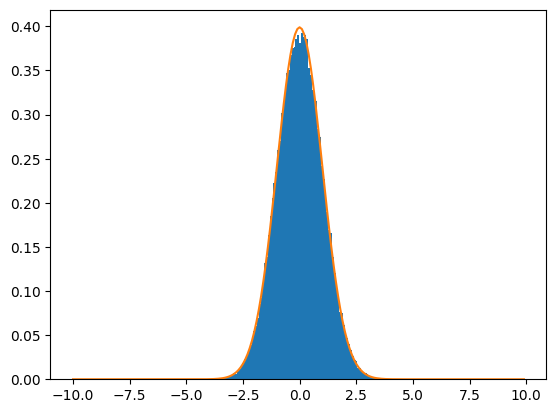

### Approach 2

We can alternatively start with a Markov chain that we know the stationary distribution to - i.e. the Metropolis markov chain.  

In this section we are trying to reason about why the forward diffusion equation generated a probability distribution $P(x) \propto \exp[-E(x)]$.  The algorithm that we described is clearly a Markov chain - i.e. the probabilistic locations of the next step only depend on the current locations.  Therefore there neeeds to be some stationary distribution.  Our goal is just to figure out which one.  Unfortunately, we don't know how to easily reason about the stationary distributions.  Let's see if instead we can start with a markov chain that we do understand and which generates the right distribution and massage it into the equation above.

One markov chain we do understand is the metropolis method.  In the metropolis method, we know that we should choose a move from $x$ to $x'$ with probability $T(x \rightarrow x')$ and then we should accept that move with probability

$$ A(x\rightarrow x') = \frac{\pi(x')}{\pi(x)} \frac{T(x' \rightarrow x)}{T(x \rightarrow x')}$$

Let's start with moving with simply a guassian with standard deviation $\sqrt{\delta}$.  Then 

$$T(x \rightarrow x') = T(x' \rightarrow x) = \exp\left[-\frac{(x-x')^2}{2\delta}\right]$$

Then we should accept with probability 

$$A(x \rightarrow x') = \exp[-E(x')-E(x)]$$


This will give us a markov chain which samples the probability distribution $p(x) \propto \exp[-E(x)]$ but unfortunately doesn't look like our dynamics above.

:::{admonition} Grading
:class: caution

Nonetheless, go ahead and implement this markov chain using the quadratic energy $E(x)=x^2/2$ and verify that it gives the right distribution.

:::

Acceptance:  0.9037


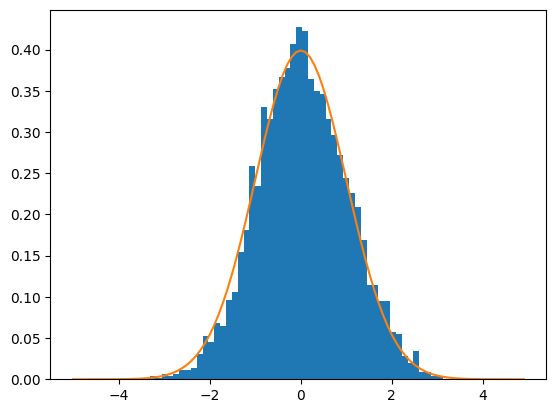

Now, we are going to go ahead and try to massage our Metropolis MCMC into something that looks more like our target dynamics.  Let us now try a new sample probability using 

$$T(x \rightarrow x') = \exp\left[-\frac{((x+\delta/2 F(x))-x')^2}{2\delta}\right]$$

What this probability distribution tells us is that we should first drift our particle from $x \rightarrow x+\frac{\delta}{2} F(x)$ and then sample a gaussian with standard deviation $\sqrt{\delta}$ from that point.  This, in fact, is the langevin dynamics described above. 

Using Metropolis, let's work out the acceptance probability $A(x \rightarrow x')$ for this new choice.

$$ \frac{T(x' \rightarrow x)}{T(x \rightarrow x')} = \exp\left[\delta (x-x')[F(x)+F(x')] +(\delta/2)^2 (F(x)^2 - F(x')^2)  \right]$$

We will find that the acceptance ratio $A(x \rightarrow x')$ approaches 1 if the potential is linear over a range of $\sqrt{\delta}$. One can see this analytically.   Instead let's go ahead and test this by running a variational Monte Carlo using this improved move.    Notice, that this is guaranteed to sample the right distribution.  If the acceptance ratio is 1 (or essentially 1) then we are guaranteed that the dynamics above actually do sample the correct thing. 

:::{admonition} Grading
:class: caution

Go ahead and show that the acceptance ratio is 1 by running this in a Monte Carlo and computing the acceptance ratio. 

In addition, you can check this by choosing a series of $x$ points (no Monte Carlo involved), choose an $x'$ by the Langevin equation and verify that the acceptance ratio for this would be essentially 1.0 if you made this move. Use $\delta =0.05$

:::

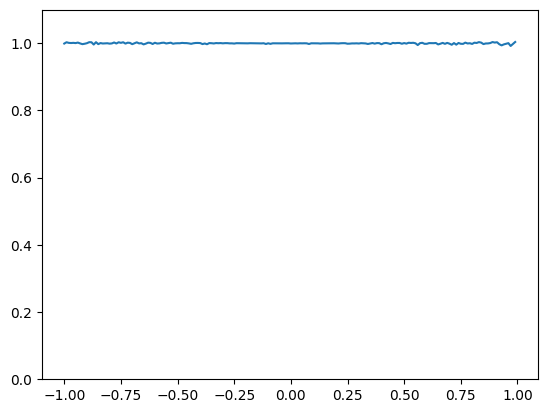

Acceptance:  0.9994


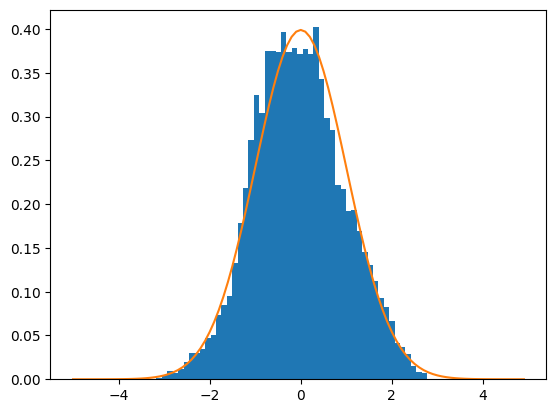

## Approach 3

The two previous approaches were essentially showing that the Langevin equation gives us the stationary distribution we want numerically.  We can also show this analytically.

Starting from a generalized version of the Langevin eqution, $x(t + \Delta t) = x(t) + l(t) + F\gamma\Delta T$, where $l(t)$ is essentially any reasonable symmetric random perturbations

you can show that this satisfies the diffusion equation, 

$$ \frac{\partial \rho}{\partial t} = D \frac{\partial^2 \rho}{\partial x^2} - \gamma F \frac{\partial \rho}{\partial x}$$

A nice exposition of this is in [James Sethna's Stat Mech Book](https://sethna.lassp.cornell.edu/StatMech/EntropyOrderParametersComplexity20.pdf) around equations 2.7. 

It's pretty easy from this equation to see that it corresponds to the drift, diffusion step of the Langevin equation - i.e. formally the solution of $\frac{\partial \rho}{\partial t} = (\hat{A} + \hat{B})\rho$ for small t is $\rho(t) = \exp[i A t] \exp[i B t]$ which directly corresponds to the drift and diffusion term.

It's also easy to work out what the stationary distribution of this equation as $\frac{\partial \rho}{\partial t} = 0$ giving us that 

$$  D \frac{\partial^2 \rho}{\partial x^2}  = \gamma F \frac{\partial \rho}{\partial x}$$

which is satisfied by 

$$ \rho(x) = A \exp\left( -\frac{\gamma}{D} E(x) \right)$$


Interestingly, this is very closely related to a method for simulating quantum ground states - diffusion Monte Carlo.

## The Next Step: Faster Diffusing 

So far, we've learned that the Langevin dynamics (in the limit of small-ish delta) are a Markov chain which ends up in the probability distribution proportional to $p(x) \propto \exp[-E(x)]$.

We are now going to focus explicitly on the energy functional for a harmonic oscillator $E(x) = x^2/2$ and we are going to generalize our diffusion to allow different step sizes at each step (as well as do a somewhat unfortunate change of variables - this will ensure that we are consistent with both the Langevin literature (from above) and the diffusion literature (now below).

Using this energy function, we get 

$$x_t= x_{t-1} \left(1- \frac{\delta}{2}\right) + \sqrt{\delta} z$$

We know are going to let $\delta$ be a function of time giving us

$$x_t= x_{t-1} \left(1- \frac{\delta_t}{2}\right) + \sqrt{\delta_t} z$$

and then let $\beta_t = \delta_t$ and $\sqrt{1-\beta_t} = \left(1- \frac{\delta_t}{2}\right)$

This last identification is true in the limit of small $\delta_t$ (just taylor expand the exponential) and is commonly what is done in the literature so we are going to do it here.  There is probably no deep fundamental reason to do so.

This leaves us 

$$x_t= x_{t-1} \sqrt{1-\beta_t} + \sqrt{\beta_t} z$$


We will now let $\beta_t = 0.0001 + (0.02-0.0001)/200 t$  
This can be generated in python by just doing 
`beta = np.linspace(0.0001, 0.02, timesteps,dtype=np.float32)`

Update your function
`def ForwardDiffusion(x_0,beta_t,timeSteps):`

to run forward diffusion over a certain number of time-steps using a time-dependent standard deviation $\beta_t$.  


:::{admonition} Grading
:class: caution

Make a plot for five runs a graph of location at time $x(t)$ vs $t$. 


This time it doesn't make sense to collect the probability distribution over many steps because the probability distribution changes over time.  
Instead, run your function 10000 times out to a time-step of T=199 and graph a histogram of the resulting distribution x(199).  Plot a theory curve on top of it showing that you get the correct probability distribution.



:::


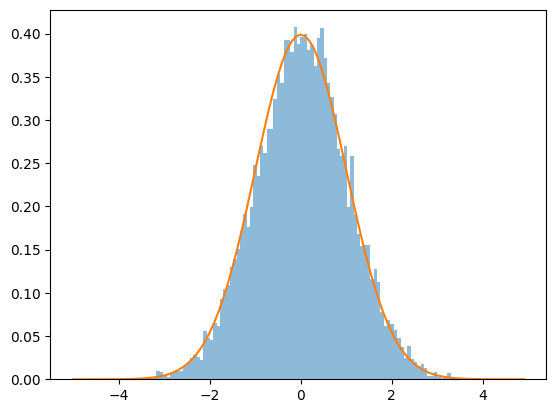

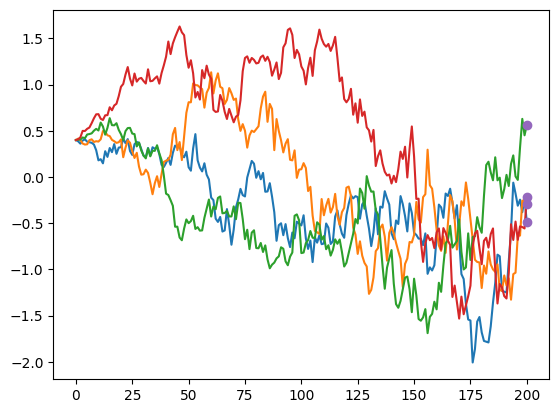

Now, we would like to produce a new function which produces the same probability distribution but does it quickly.  In other words, you want to produce the same probability distribution after some number of time steps but which doesn't require taking each and every step to get there (i.e. you just want to be able to jump to step 150).  It turns out that this possible because the sum of a bunch of random gaussian steps is a random gaussian step. 

If we let 
$$\alpha_t = 1-\beta_t$$
and 
$$\overline{\alpha_t}= \prod_{i=1}^t \alpha_t$$

then you can jump to step $T$ from initial point $x_0$ by doing

$$\sqrt{\overline{\alpha_t}} x_0 + \sqrt{1-\overline{\alpha_t}} z$$

:::{admonition} Grading
:class: caution


Go ahead and write a 
`def ForwardDiffusionFast(x_0,alpha_bar_t,timeSteps):`
which quickly generates the same distribution as ForwardDiffusion.  Plot a histogram of ForwardDiffusionFast out to T=200 and check that you get the same probability distribution as ForwardDiffusion

:::

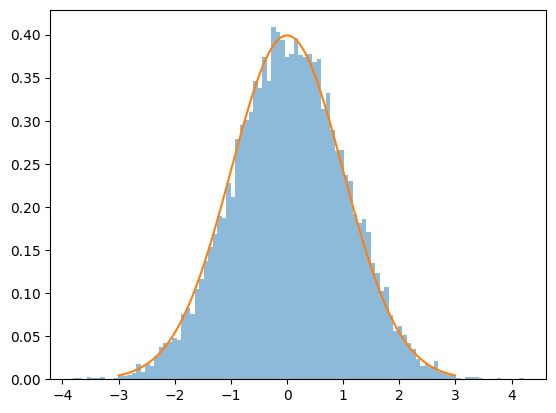

## Undiffusing

Our next step is to figure out how to undiffuse.    

In our forward diffusion process we have samples $x_0$ from an initial distriution $p_{init}(x_0)$ which we forward diffuse 
```
x0 = SamplePInit()
xt = ForwardDiffusionFast(x_0,T,alpha_bar)
```
giving us a (largely gaussian) final distribution $p_{final}$.

Now, we'd like to start with samples $x_t$ from $p_{final}$ and write a function `Undiffuse(xt)` which returns a sample $x_0$ which is sampled from $p_{init}$ - i.e.

```
x0 = SamplePInit()
xt = ForwardDiffusionFast(x_0,T,alpha_bar)
new_x0 = Undiffuse(xt) 
# new_x0 doesn't have to be x_0 but if we histogram $new_x0$ and $x_0$ those histograms should be the same
```


In some sense, this should be possible - the laws of physics don't know about the direction in time.  In practice though, you don't often see things undiffuse even if we reverse the force (i.e. after a drop of food coloring diffuses in a cup, it doesn't undiffuse by turning it upside-down.) The reason for this is that we aren't actually successfully reversing the directions of "all the air molecules bouncing off the pollen" even if we do reverse the force on the pollen.  Nonetheless, if we are careful (and have the right information) we can get this undiffusion to happen.   Mathematically, what we need to do is figure out how to (stochastiaclly) run the Langevin Markov chain backwards.

The Langevin markov chain is a rule which tells us, given $x_{t-1}$ how we should stochastically choose $x_t$ - i.e. it is defined by $p(x_t | x_{t-1})$.

To reverse it, we would like to figure out $p(x_{t-1} | x_{t})$.   It turns out we can't quite do this.  Instead, what we are going to do is get a rule for $p(x_{t-1} | x_{t},x_0)$.  In practice, then to run our markov chain backwards we start with $x_t$, guess the $x_0$ that would have generated that $x_t$, and then use our rule to get $x_{t-1}$.  We can then do this over and over again decreasing $t$ until we get to $t=0$.  Actually it will turn out to be slightly preferable to guess the random number $z_g^t$ used in your fast diffusion function (i.e. the result of the call to `np.random.randn()`) then $x_0$.  But since you can get $x_0$ given $z_g^t$ and $x_t$ it's equivalent.





:::{admonition} Derivation
:class: dropdown

Let's go ahead and derive the rule for $p(x_{t-1}|x_t,x_0)$.  

First start by looking at $p(x_t, x_{t-1}, x_0)$.   We can expand this out using Bayes theorem as 

$p(x_t, x_{t-1}, x_0) = p(x_t | x_{t-1}, x_0) p(x_{t-1}|x_0) p(x_0)$

and 

$p(x_t, x_{t-1},x_0) = p(x_{t-1}| x_t,x_0) p(x_{t}|x_0)p(x_0)$

Some algebra then gives us 
$p(x_{t-1}|x_t,x_0) = p(x_t| x_{t-1},x_0)\frac{p(x_{t-1}|x_0)}{p(x_t|x_0)}$

Notice the first term on the rhs doesn't depend on $x_0$ (it's a markov chain and so if you tell me $x_{t-1}$ I don't also need $x_0$.  

Using our fast diffusion this gives us 


$p(x_{t-1}|x_t,x_0) = \exp\left[-\frac{1}{2}\left(\frac{(x_t-\sqrt{\alpha_t}x_{t-1})^2}{\beta_t}  + \frac{ (x_{t-1}-\sqrt{\overline{\alpha_{t-1} } } x_0)^2}{1-\overline{\alpha_{t-1}}} - \frac{( x_t - \sqrt{\overline{\alpha_t}}x_0)^2}{1-\overline{\alpha_t}} \right)   \right]$


You can simplify this by rewriting this as 
$$p(x_{t-1} | x_t, x_0) = \frac{1}{\sqrt{2\pi \tilde{\beta_t}}} \exp\left[-\frac{(x-\tilde{\mu}_t)^2}{2\tilde{\beta_t}}\right]$$


where 
$$\tilde{\mu}_t= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0 $$

and 
$$\tilde{\beta_t} = \frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_t} \beta_t$$


This tells us that our undiffusion step should be (after guess $x_0$)

$$x_{t-1} = x_t + \tilde{\mu}_t + N(0,1) \sqrt{\tilde{\beta_t}}$$
(technical note: we don't do the N(0,1) step when $t=0$)

Now from our fast diffusion we have that 

$x_0 = \frac{1}{\sqrt{\overline{\alpha}_t}} (x_t - \sqrt{1-\overline{\alpha}_t}z^g_t)$
where $z^g_t$ is our guess for the noise from foward diffusion (i.e. instead of guess $x_0$ we can guess the noise we used to get $x_t$).  

We can plug $x_0$ into our diffusion step.  Using some algebra we end up with the following:

:::

When we work this all out the undiffusing step gives us (after we guess the random noise)


$$x_{t-1}=\frac{1}{\sqrt{\alpha_t}} (x_t - s_t * z^g_t) + \delta_{t,0} \sqrt{\tilde{\beta_t}} N(0,1)  $$

where $\delta_{t,0}$ is 1 unless $t=0$, $z^g_t$ is your guess for the full noise used to diffuse from $t=0$, and the noise scale 

$$s_t=\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha_t}}}$$

and 

$$\tilde{\beta_t} = \frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_t} \beta_t$$


Let's go ahead and write some functions now to get this working:

Write an `Undiffuse(xt)` function which takes xt and (stochastically) returns $x_{t-1}$  In this function you are going to write call `GuessZ(xt)` which you will also write.  

The `Undiffuse` function is generic.  We will also write a `SamplePInit()` function.  For our first example, we will make it always return 0.4.  In other words, our probability distribution is $p(0.4)=1$ and $p(x\neq 0.4)=0$.

Also go ahead and write `GuessZ`.   In this case, since you (secretly) know that $x_0$ is always $0.4$ you can probably do a really good job of having guessZ successfully guess the right random noise :) 


:::{admonition} Grading
:class: caution

Once these functions are written, let's work on the undiffusion. 


* Run your undiffusion 5 times starting all from a single diffused point.  Graph $x(t)$ vs $t$

* Run your undiffusion many times out to T=0.  Show that you get a delta function at 0.4

* Run your diffusion from T=0 to T=125 and your undiffusion from T=200 to T=125 and plot the histograms showing they are the same. 

:::

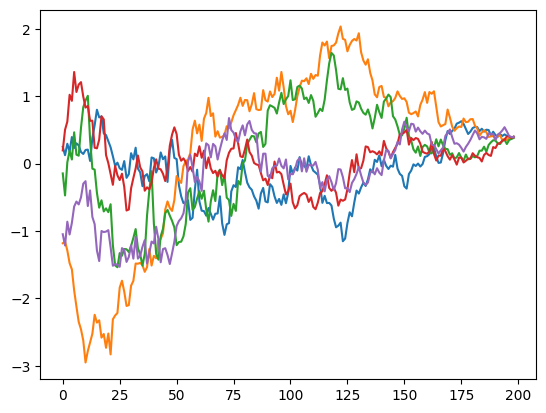

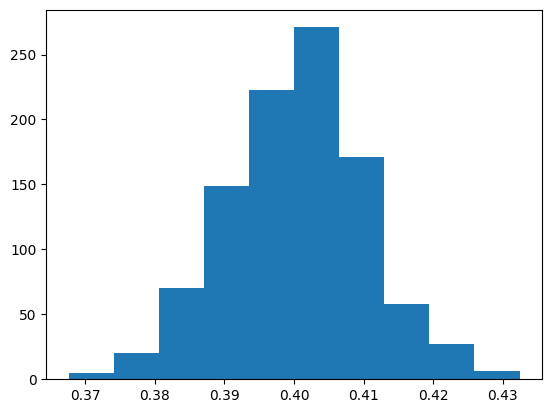

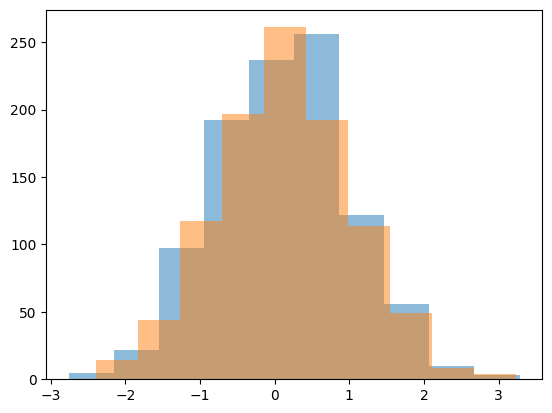

We now want to make life a little harder.  We are going to have a new probability distribution.  

$$p(0.4) = 0.8$$
$$p(-0.6) = 0.2$$
$$p(anything else) = 0$$

Write the new `SampleFromInitP` function.

Now we also need a new `guessZ(xt)` function.  Notice that this is much trickier and doesn't always have an obvious answer.  If I tell you what $x_t$ is, you don't really know which $x_0$ it came from (maybe 0.4 and maybe -0.6).  Therefore, you don't know whether to report $z_{0.4}$ (i.e. the random guess from 0.4) or to report $z_{-0.6}$.  It turns out the right thing to do is to report is the weighted average

$$\frac{0.8 z_a \exp(-z_a^2/2) + 0.2 z_b \exp(-z_b^2/2)}{(0.2\exp(-z_a^2/2)+0.8\exp(-z_b^2/2)}$$


:::{admonition} Grading
:class: caution

Do the undiffusion from this probabaility distribution.  Plot the same plots from the undiffusion from a single delta function.


In addition, notice that at each step in your diffusion you are making a guess for z.  This corresponds to a guess for $x_0$.  For ten runs, graph the guess as a function of t. 
:::



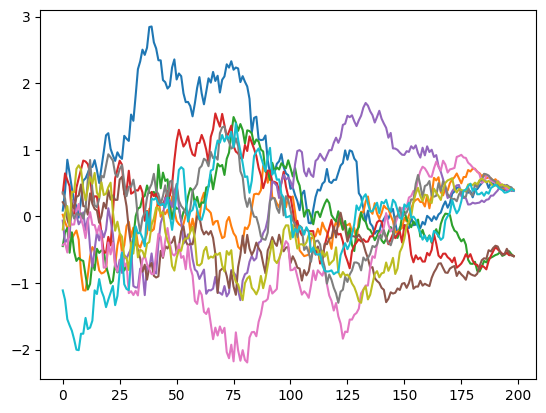

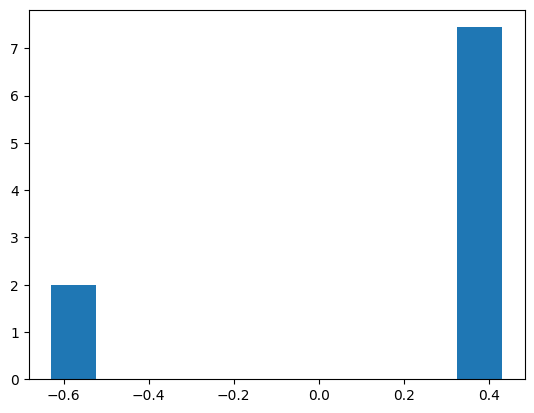

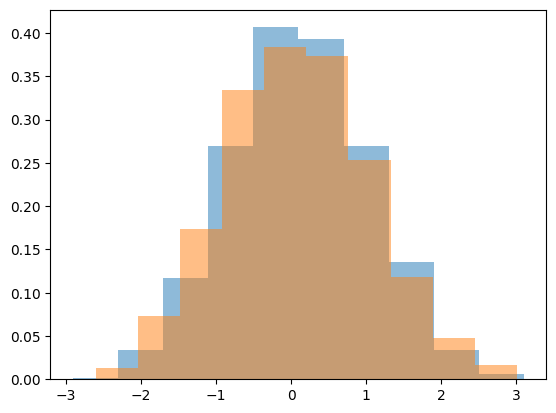

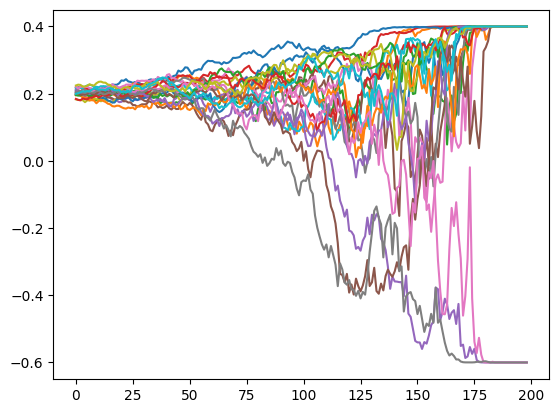

## Training

So far we've managed to do undiffusion where we know what the right guess for the random number $z_g$ is.  But in practice we don't always know this.  Now, we'd like to work in a situation where we don't know this.  Instead, we are going to train a neural network which learns the noise.  

To do this, we are going to use pytorch.  To generate a simple neural network using pytorch, we can have 
```
import torch
import torchvision
from torch import nn

n_input, n_hidden, n_out = 2, 15, 1
net = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      )
net(torch.tensor([3.0,4]))  <--This runs the network with a noise of 3 at time-step 4
```



Now, we need to learn how to use pytorch to train a network to match the noise.  Essentially what we are going to do is the following:

* Pick a random $t$
* Get from your ForwardDiffusionFast function both the noise (<--this is a new thing you have to return) and the noisy data.
* Have your network guess the noise.  Using a loss-function modify your network to match the noise more closely.

Here is the general framework for pytorch optimization.  You have to define some optimization pieces.

```
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

for step in range(0,200000):
  opt.zero_grad()
  x0= SamplePInit()
  # Choose a random time t
  
  # call your FowardDiffusionFast (make sure you return the noisyData and the noise)
  noisyData=torch.tensor([noisyData,t]).float() # include the time for the data
  noise=torch.tensor([noise]) #make it so pytorch reads the noise

  loss=loss_fn(noise,net(noisyData))
  loss.backward()
  opt.step()  
```

Note that `loss.item()` gives you the loss.


Fill out your optimization.  Run it and you should then have a net which guesses your random noise. 



:::{admonition} Grading
:class: caution

Train your network.  Plot the loss as a function of training step.  You may have to do a window averaging over approximately 100 steps to generate this plot. 

:::


Now in your undiffuse, you can make your `guess=net(torch.tensor([float(x_t),t]))` as opposed to calling model guess. Go ahead and make this replacement and then run your undiffusion generating both the standard 10 samples of undiffusion as well as the histogram as well as the best guess.  


:::{admonition} Grading
:class: caution

Generate these plots.

:::


